### import modules

In [1]:
import tweepy
import json
import os
import csv
from textblob import TextBlob
import re
import pandas as pd
import numpy as np
from elasticsearch import helpers, Elasticsearch
from datetime import datetime as dt
from geopy.geocoders import Nominatim

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize']=(20,18)

### Hashtag to lookup

In [3]:
TAG = 'Sam Petrova'
HASHTAG = "#"+ TAG


### Twitter Auth & Auth

In [9]:
# OAuth process, using the keys and tokens
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)


### Sentiment Analysis

In [10]:
def clean_tweet(tweet):
    '''
    Utility function to clean tweet text by removing links, special characters
    using simple regex statements.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\\w+:\\/\\S+)", " ", tweet).split())

def get_tweet_sentiment(tweet):
    '''
    Utility function to classify sentiment of passed tweet
    using textblob's sentiment method
    '''
    # create TextBlob object of passed tweet text
    analysis = TextBlob(clean_tweet(tweet))
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'


 ### File Path

In [23]:
# LC_path_json = 'data/language_code.json'
# os.chdir('..')
tweet_csv = os.getcwd()+'/arghya/Documents/DataValAnalysis/data/'+TAG+'.csv'
print_to_csv = 'data/'+TAG+'.csv'
# os.chdir('..')
# jsonfile = open(os.getcwd()+"/"+LC_path_json, 'r')
api = tweepy.API(auth)
fieldnames = ("code","lang")
# reader = jsonfile.read()
print(tweet_csv)

/home/arghya/Documents/DataValAnalysis/data/Raga.csv


### Tweet Scrapper

In [24]:
# api.trends_place(["bangalore"])
api.trends_closest(22.3511148, 22.3511148)

[{'name': 'Egypt',
  'placeType': {'code': 12, 'name': 'Country'},
  'url': 'http://where.yahooapis.com/v1/place/23424802',
  'parentid': 1,
  'country': 'Egypt',
  'woeid': 23424802,
  'countryCode': 'EG'}]

search = tweepy.Cursor(api.search, q=HASHTAG, result_type="mixed", tweet_mode='extended').items(2000)
geolocator = Nominatim(user_agent="dataval", timeout=200)

tweets_infos = []
i=0
try:
    for item in search:
        i+=1
        print(i)
        tweets = {}
        json_obj = item._json
        tweets['tweet_text'] = json_obj['full_text'].replace('\n', ' ').replace('\r', '') if 'full_text' in json_obj else ""
        tweets['created_at'] = dt.strptime(json_obj['created_at'], "%a %b %d %H:%M:%S %z %Y").strftime("%Y-%m-%d %H:%M:%S") if 'created_at' in json_obj else ""
        tweets['reTweetCount'] = item.retweet_count
        hashtags_array = []
        if 'entities' in json_obj and 'hashtags' in json_obj['entities']:
            for e in json_obj['entities']['hashtags']:
                hashtags_array.append(e['text'])
        tweets['hashtags'] = hashtags_array
        if 'metadata' in json_obj and 'iso_language_code' in json_obj['metadata']:
            for each_lang in json.loads(reader):
                if each_lang['code'] == json_obj['metadata']['iso_language_code']:
                    tweets['lang_type'] = each_lang['lang']
                    break
                else:
                    tweets['lang_type'] = ''
        else:
            tweets['lang_type'] = ''

        tweets['result_type'] = json_obj['metadata']['result_type'] if 'metadata' in json_obj and 'result_type' in json_obj['metadata']else ""
        print(json_obj['user']['location'])
        letters = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
        numbers = "012345789"
        if len(json_obj['user']['location']) > 0:
            if item.coordinates is None and json_obj['user']['location'][0] not in letters or json_obj['user']['location'][0] not in numbers:
                location = geolocator.geocode(json_obj['user']['location']) if 'user' in json_obj and 'location' in json_obj['user'] else ""
                tweets['coordinates'] = str(location.latitude) + str(',') + str(location.longitude) if location is not None else ""
                tweets['location'] = json_obj['user']['location'] if 'user' in json_obj and 'location' in json_obj['user'] else ""
            elif item.coordinates is not None:
                tweets['coordinates'] = item.coordinates
                tweets['location'] = json_obj['user']['location'] if 'user' in json_obj and 'location' in json_obj[
                    'user'] else ""
            else:
                tweets['coordinates'] = ""
                tweets['location'] = ""
        else:
            tweets['coordinates'] = ""
            tweets['location'] = ""
        tweets['source'] = item.source
        tweets['sentiment'] =  get_tweet_sentiment(item.full_text)
        tweets['description'] = item.author.description if item.author.description is not None else ""
        tweets['author_favaourites_counts'] = item.author.favourites_count if item.author.favourites_count is not None else ""
        tweets['author_followers_counts'] = item.author.followers_count if item.author.followers_count is not None else ""
        tweets['author_friends_counts'] = item.author.friends_count if item.author.friends_count is not None else ""
        tweets['status_count'] = item.author.statuses_count if item.author.statuses_count is not None else ""
        tweets['tweet_id'] = item._json['id'] if 'id' in item._json else ""
        tweets['truncated'] = json_obj['truncated'] if 'truncated' in json_obj else ''
        tweets['in_reply_to_status_id'] = json_obj['in_reply_to_status_id'] if 'in_reply_to_status_id' in json_obj else ''
        tweets['in_reply_to_status_id_str'] =  json_obj['in_reply_to_status_id_str']  if 'in_reply_to_status_id_str' in json_obj else ''
        tweets['in_reply_to_user_id'] = json_obj['in_reply_to_user_id'] if 'in_reply_to_user_id' in json_obj else ''
        tweets['user_id'] = json_obj['user']['id'] if 'user' in json_obj and 'id' in json_obj['user'] else ''
        tweets['user_name'] = json_obj['user']['name'] if 'user' in json_obj and 'name' in json_obj['user'] else ''
        tweets['user_time_zone'] = json_obj['user']['time_zone'] if 'user' in json_obj and 'time_zone' in json_obj['user'] else ''
        tweets['place'] = json_obj['place'] if 'place' in json_obj else ''
        tweets['contributors'] = json_obj['contributors'] if 'contributors' in json_obj else ''
        tweets['retweeted'] = json_obj['retweeted'] if 'retweeted' in json_obj else ''
        tweets['favorited'] = json_obj['favorited'] if 'favorited' in json_obj else ''
        tweets['possibly_sensitive'] = json_obj['possibly_sensitive'] if 'possibly_sensitive' in json_obj else ''



        if len(tweets) > 0:
            tweets_infos.append(tweets)
    jsonfile.close()
except Exception as e:
    print(e)
    with open(tweet_csv, 'w',encoding="utf-8") as f:
        # Assuming that all dictionaries in the list have the same keys.
        if len(tweets_infos) > 0:
            headers = sorted([k for k, v in tweets_infos[0].items()])
            csv_data = [headers]

            for d in tweets_infos:
                csv_data.append([d[h] for h in headers])

            writer = csv.writer(f)
            writer.writerows(csv_data)
    f.close()
    print("csv file created")


with open(print_to_csv, 'w',encoding="utf-8", newline='') as f:
    # Assuming that all dictionaries in the list have the same keys.
    if len(tweets_infos) > 0:
        headers = sorted([k for k, v in tweets_infos[0].items()])
        csv_data = [headers]

        for d in tweets_infos:
            csv_data.append([d[h] for h in headers])

        writer = csv.writer(f)
        writer.writerows(csv_data)
f.close()


### Tweets Batch file read

In [25]:
tweets_data = pd.read_csv(tweet_csv)

In [26]:
tweets_data.head()

favourites_count  followers_count  \
0              8206              222   
1             40451              279   
2             60731             1231   
3             41170             1140   
4              6063              531   

                                            hashtags  retweet_count  \
0                                                 []              4   
1                                                 []              4   
2                                                 []              4   
3                                                 []              4   
4  ['InternationalWomensDay', 'RaGa', 'NidhiRazda...              4   

                                          tweet_text  
0  RT @Ashtalakshmi8: @vanitajain21 @Ramesh_BJP @...  
1  RT @Ashtalakshmi8: @vanitajain21 @Ramesh_BJP @...  
2  RT @Ashtalakshmi8: @vanitajain21 @Ramesh_BJP @...  
3  RT @Ashtalakshmi8: @vanitajain21 @Ramesh_BJP @...  
4  @vanitajain21 @Ramesh_BJP @pandey_indrani @nid...

### Import visualization modules

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### Pie chart of variation of tweet wrt to languages

tweet = tweets_data.groupby(['lang_type']).count()
df1 = tweet.reset_index(level=['lang_type'])
#for row in tweet[['location']].iterrows():

language = df1['lang_type'].tolist()
#print(language)
tweets_count = df1['tweet_text'].tolist()


trace = go.Pie(labels=language, 
               hoverinfo='label+percent', 
               values=tweets_count, 
               textposition='outside',
               #marker=dict(colors=color_palette_list[0:2]),
              rotation=90)
layout = go.Layout(
                    title="Language make-up of twitter traffic",
                    font=dict(family='Arial', size=12, color='#909090'),
                    legend=dict(x=0.9, y=0.5)
                    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic_pie_chart_elephant_in_the_valley')

###  Pie chart of tweets wrt sentiments

In [29]:
import matplotlib
matplotlib.rcParams['figure.figsize']=(6,8)

In [36]:
tweet = tweets_data.groupby(['sentiment']).count()
df1 = tweet.reset_index(level=['sentiment'])
print("printing df1")
print(df1.head())
sentiment = df1['sentiment'].tolist()
#print(sentiment)
tweets_count = df1['tweet_text'].tolist()
#print(tweets_count)

fig1, ax1 = plt.subplots()
explode = (0, 0, 0.1)
ax1.pie(tweets_count, explode=explode,labels=sentiment,colors=['blue','skyblue','orange'], autopct='%1.1f%%',
        shadow=True, rotatelabels=True, startangle=90,radius=1.5)

#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Sentiment percentage of twitter traffic",y=1,x=1.5,bbox={'facecolor':'0.9', 'pad':5})

plt.show()

KeyError: 'sentiment'

### Top 50 most retweeted tweets

In [35]:
tweet = tweets_data12.sort_values('reTweetCount',ascending=False).head(n=50)
tweet_plot = tweet[['reTweetCount','tweet_text']]
#print (tweet_plot)
trace = go.Table(
    header=dict(values=list(tweet_plot.columns),
                height = 40,
                 line = dict(color = '#506784'),
                fill = dict(color = '#119DFF'),
                font = dict(color = 'white', size = 12),
                align = ['left'] * 5),
    cells=dict(values=[tweet_plot.reTweetCount, tweet_plot.tweet_text],
               height = 30,
               line = dict(color = '#506784'),
               fill = dict(color = ['#25FEFD', 'white']),
               font = dict(color = '#506784', size = 12),
               align = ['left'] * 5))

data = [trace] 
py.iplot(data, filename = 'join2saurav')

KeyError: 'reTweetCount'

### Wordcloud of most frequent hashtags 

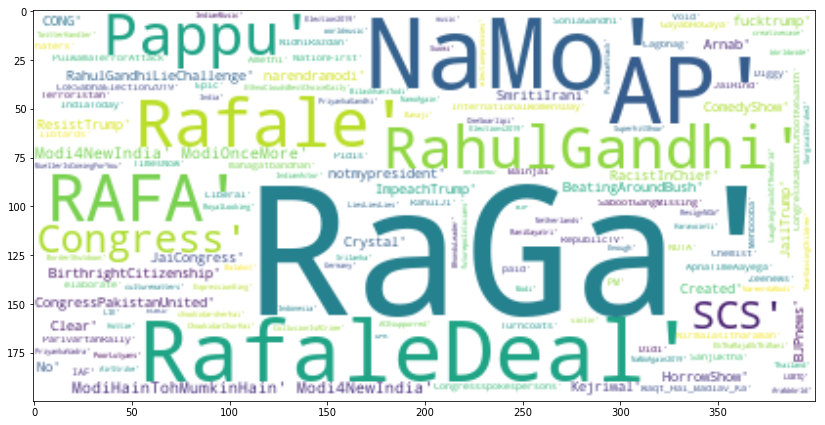

In [37]:
import matplotlib
matplotlib.rcParams['figure.figsize']=(14,16)
tweets_data.head(5)
hashtags = tweets_data['hashtags'].tolist()
text = ""
for lst in hashtags:
    for wrd in str(lst).split(","):
        text += " "+wrd.strip()
        
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("on")
plt.show()
#print(hashtags)

### Device types of twitter users

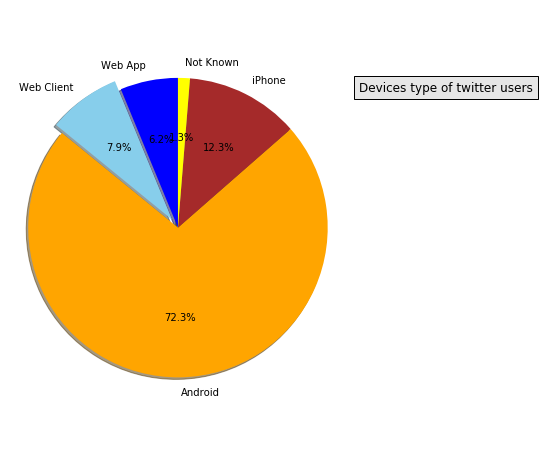

In [97]:
import matplotlib
matplotlib.rcParams['figure.figsize']=(6,8)
tweet = tweets_data.groupby(['source']).count()
df1 = tweet.reset_index(level=['source'])
tweets_count = df1['tweet_text'].tolist()
#print(tweets_count)
tweets_source = df1['source'].tolist()
#print(tweet.head())
source_lst = []
unknown_types = []
i=0
un_index = 0
for source in tweets_source:
    if (source.find('Android') != -1): 
        if 'Android' not in source_lst:
            source_lst.append('Android')
    elif (source.find('Web Client') != -1):
        if 'Web Client' not in source_lst:
            source_lst.append('Web Client')
    elif (source.find('Web App')!=-1):
        if 'Web App' not in source_lst:
            source_lst.append('Web App')
    elif(source.find('iPhone')!=-1):
        if 'iPhone' not in source_lst:
            source_lst.append('iPhone')
    else:
        source_lst.append('Unknown Type')
        unknown_types.append(i)

    i += 1
    

count_of_utype = 0
k=0
for ind in unknown_types:
    count_of_utype += tweets_count[ind-k]
    del source_lst[ind-k]
    del tweets_count[ind-k]
    k +=1


source_lst.append("Not Known")
tweets_count.append(count_of_utype)


fig1, ax1 = plt.subplots()
explode = (0, 0.1, 0,0,0)
ax1.pie(tweets_count, explode=explode,labels=source_lst,colors=['blue','skyblue','orange','brown','yellow'], autopct='%1.1f%%',
        shadow=True, startangle=90,radius=1.5)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Devices type of twitter users",y=0.8,x=1.3,bbox={'facecolor':'0.9', 'pad':5})

plt.show()


### Author's Impact

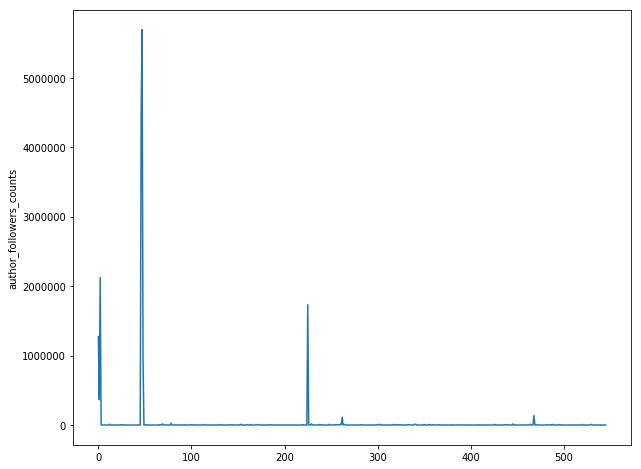

In [100]:
import matplotlib
matplotlib.rcParams['figure.figsize']=(10,8)
sns.lineplot(x=tweets_data['author_followers_counts'].index , y=tweets_data['author_followers_counts'])

### Tweets scatter plot

In [101]:
df = tweets_data
# print(df[['coordinates']])
lat_df = df.coordinates.apply(lambda x: x.split(',')[0] if x is not np.nan else np.nan)
lon_df = df.coordinates.apply(lambda x: x.split(',')[1] if x is not np.nan else np.nan)
# Lat_df['Latitude'] = 
#print(df.coordinates.head())
#print(lat_df.head())
# print(lon_df['longitude'])
#lon_df.head()
data = [
    go.Scattermapbox(
        lat=lat_df,
        lon=lon_df,
        mode='markers',
        marker=dict(
            size=9
        )
    )
]
layout = go.Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken='pk.eyJ1IjoiamFzb29zIiwiYSI6ImNqc203Njd3ajFxajA0NHBsN2J4emJqZWMifQ.wVhtH9ngNFWY6DCrl224DA',
        bearing=0,
        center=dict(
            lat=28.92,
            lon=77.07
        ),
        pitch=0,
        zoom=2
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Multiple Mapbox')

C:\Users\comp\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [102]:
import gmaps
import gmaps.datasets
gmaps.configure(api_key="AI...") # Your Google API key

df = gmaps.datasets.load_dataset_as_df('starbucks_kfc_uk')

starbucks_df = df[df['chain_name'] == 'starbucks']
starbucks_df = starbucks_df[['latitude', 'longitude']]

starbucks_layer = gmaps.symbol_layer(
    starbucks_df, fill_color="green", stroke_color="green", scale=2
)
fig = gmaps.figure()
fig.add_layer(starbucks_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [1]:
df = tweets_data
lat_df['latitude'] = df.coordinates.apply(lambda x: x.split(',')[0] if x is not np.nan else np.nan)
lon_df['longitude'] = df.coordinates.apply(lambda x: x.split(',')[1] if x is not np.nan else np.nan)

#df['text'] = df['airport'] + '' + df['city'] + ', ' + df['state'] + '' + 'Arrivals: ' + df['cnt'].astype(str)

scl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
    [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"] ]

data = [ dict(
        type = 'scattergeo',
        locationmode = 'India-states',
        lon = lon_df['longitude'],
        lat = lat_df['latitude'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = 0,
            #color = df['cnt'],
            #cmax = df['cnt'].max(),
            colorbar=dict(
                title="Incoming flightsFebruary 2011"
            )
        ))]

layout = dict(
        title = 'Most trafficked tweets location<br>(Hover for location names)',
        colorbar = True,
        geo = dict(
            scope='asia',
            #projection=dict( type='IND' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            showsubunits = True,
            showcountries = True,
            countrywidth = 2.0,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='map' )

NameError: name 'tweets_data' is not defined

In [104]:
lat_df.head()

0           NaN
1    28.5808133
2           NaN
3    28.6517178
4    -36.884429
Name: coordinates, dtype: object

['English', 'Estonian', 'Hindi', 'Urdu', 'Welsh']
[250, 1, 223, 16, 1]


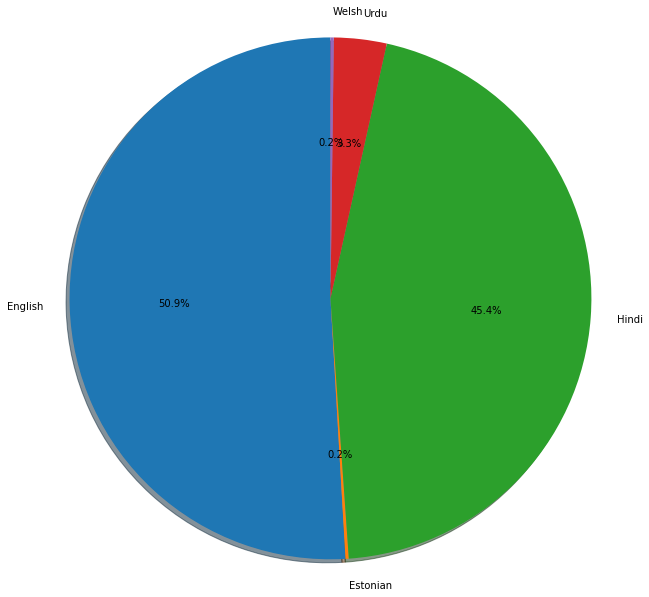

In [107]:
#pie chart of variation of tweet wrt to languages

tweet = tweets_data.groupby(['lang_type']).count()
df1 = tweet.reset_index(level=['lang_type'])
#for row in tweet[['location']].iterrows():

language = df1['lang_type'].tolist()
print(language)
tweets_count = df1['tweet_text'].tolist()

print(tweets_count)

#explode = (0, 0.1, 0.2, 0.3,0.4,0.5,0.6)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(tweets_count, labels=language, autopct='%1.1f%%',
        shadow=True, startangle=90,radius=1.5)
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()



In [84]:
l = df.coordinates.apply(lambda x: x.split(',')[0] if x is not np.nan else np.nan).head()

In [85]:
l.head()

0           NaN
1    28.5808133
2           NaN
3    28.6517178
4    -36.884429
Name: coordinates, dtype: object

{'whiskers': [<matplotlib.lines.Line2D at 0x2084d11b2e8>,
 'caps': [<matplotlib.lines.Line2D at 0x2084bb702e8>,
 'boxes': [<matplotlib.lines.Line2D at 0x2084d11b080>],
 'medians': [<matplotlib.lines.Line2D at 0x2084bb70860>],
 'fliers': [<matplotlib.lines.Line2D at 0x2084be52710>],
 'means': []}

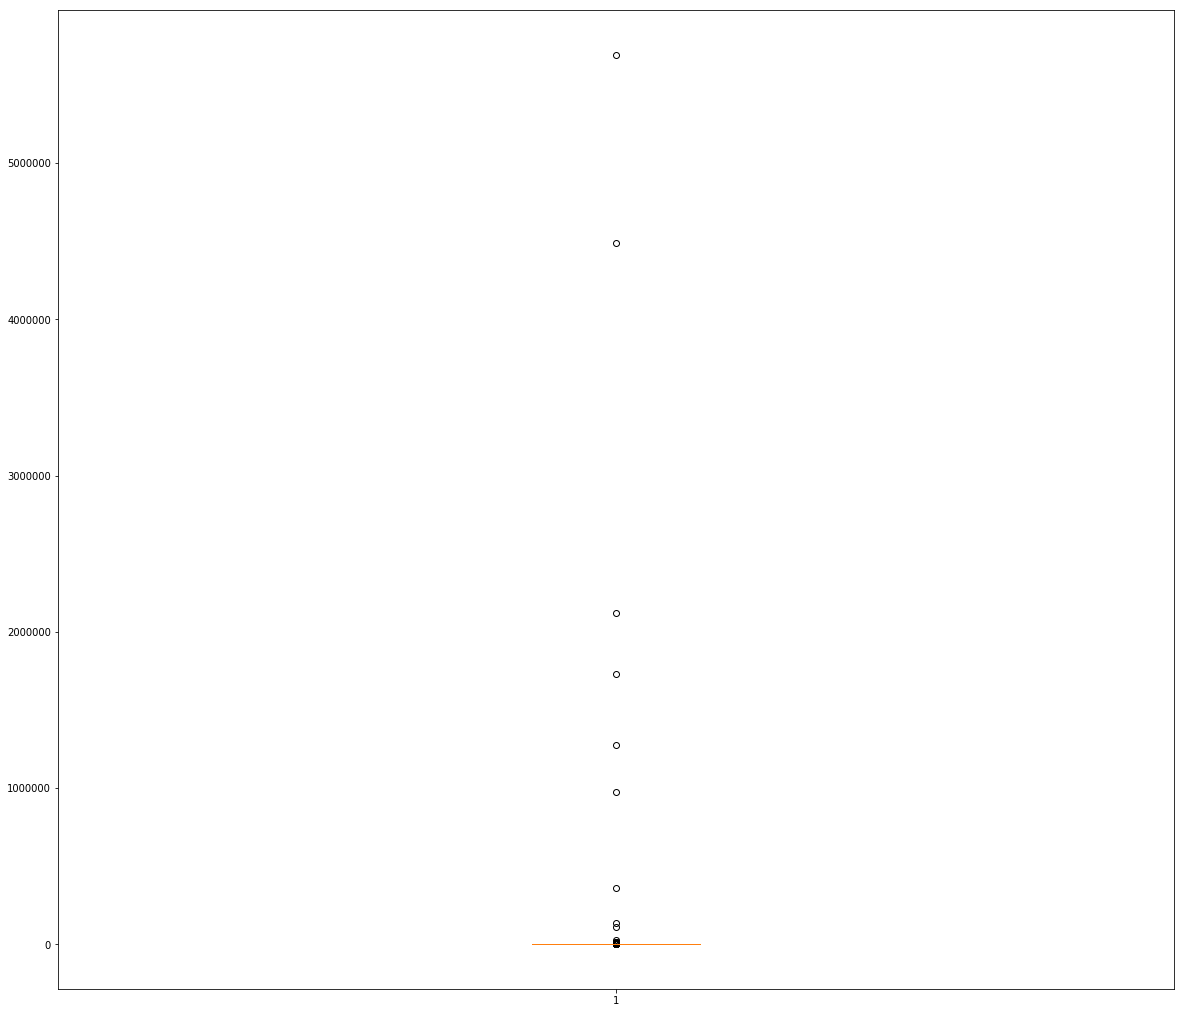

In [86]:
plt.boxplot(tweets_data['author_followers_counts'])

['English', 'Estonian', 'Hindi', 'Urdu', 'Welsh']
[184, 0, 181, 14, 1]


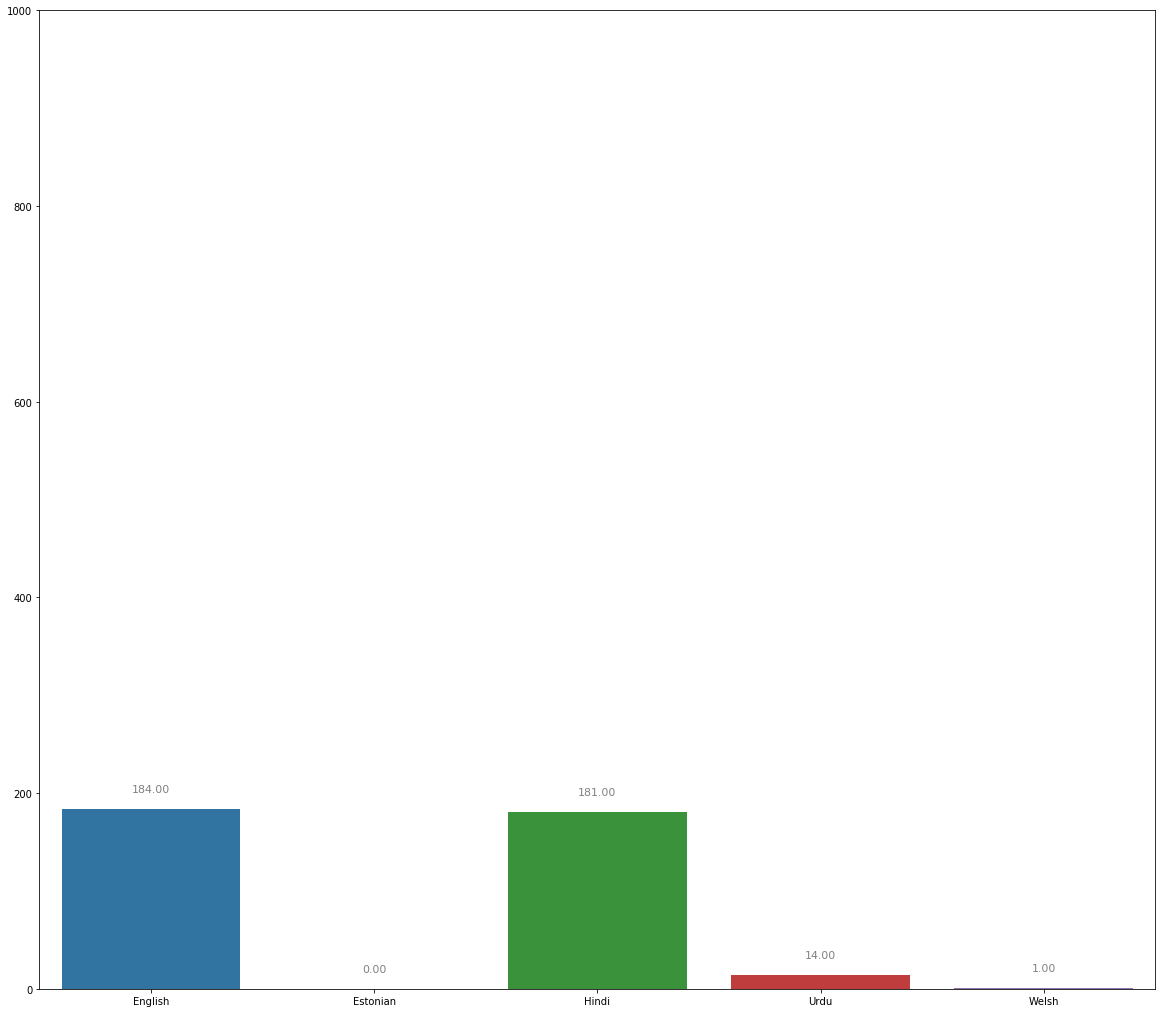

In [87]:
#bar graph of variation of tweet wrt to languages

tweet = tweets_data.groupby(['lang_type']).count()
df1 = tweet.reset_index(level=['lang_type'])
#for row in tweet[['location']].iterrows():

language = df1['lang_type'].tolist()
print(language)
tweets_count = df1['description'].tolist()
print(tweets_count)
g = sns.barplot(y=tweets_count , x = language)

ax=g
#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
_ = g.set_ylim(0,1000)

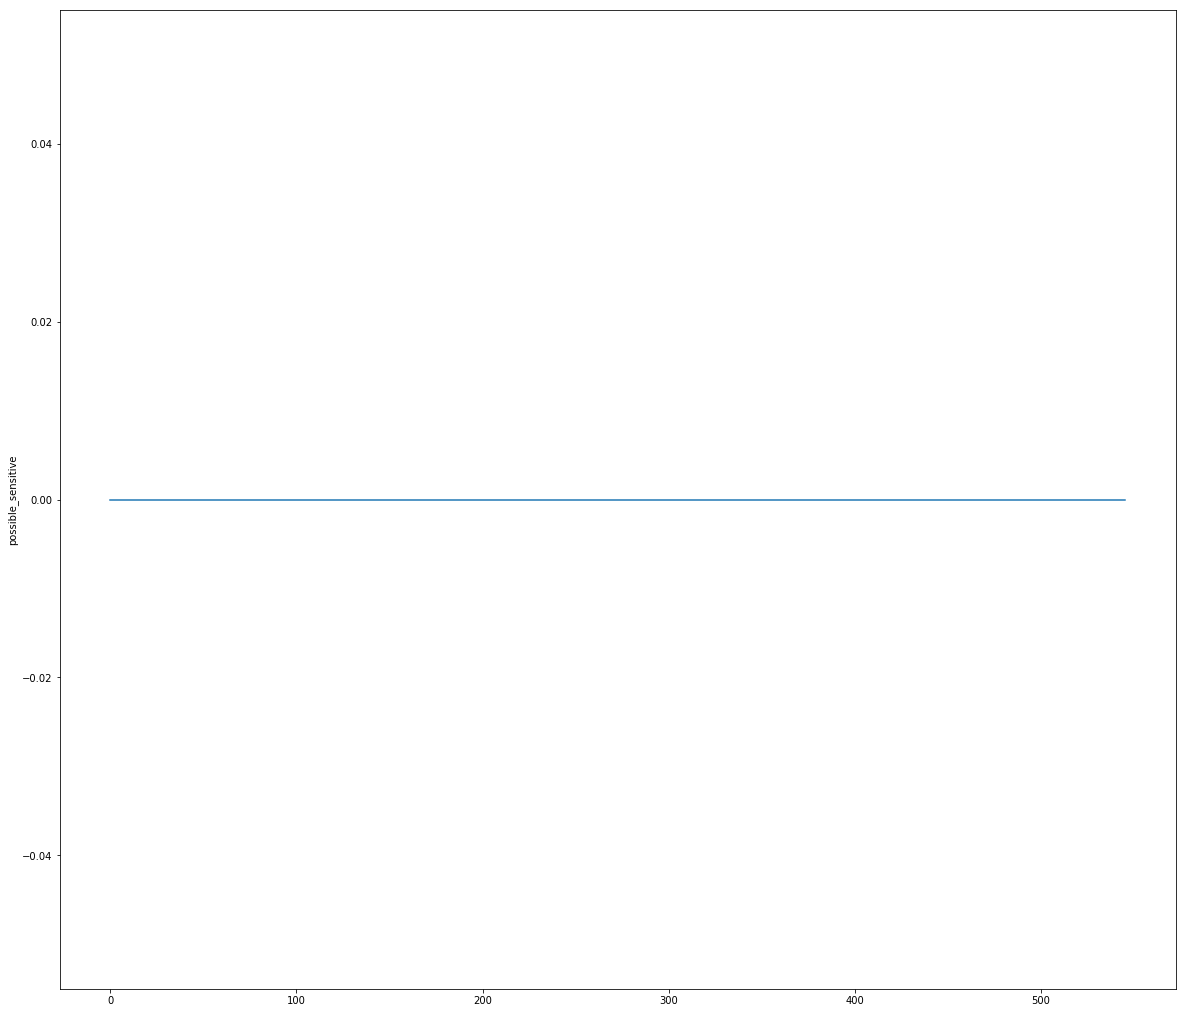

In [88]:
#possible sensitive line graph
possible_sensitive = tweets_data['possibly_sensitive'].tolist()
lst_tweets = []
for val in possible_sensitive:
    tw = []
    if val == 'TRUE':
        tw.append(1)
    else:
        tw.append(0)
    lst_tweets.append(tw)
#data =[[0],[1],[1],[0],[0],[0],[0],[0],[1],[1]]
df1 = pd.DataFrame(lst_tweets, columns = ['possible_sensitive']) 
  
sns.lineplot(y=df1['possible_sensitive'] , x =df1.index )

In [42]:
es = Elasticsearch()

In [ ]:
es.indices.delete(index='wejudge')

In [31]:
# consumer keys and access tokens, used for OAuth
consumer_key = 'kdcOWlnYEx10Oqi4VcKM6Gjam'
consumer_secret = 'sJVTx602Q0kgIiDIqVd78eeIFuUpYFLOuisfLLm1ZY2JT6D5pU'
access_token = '794180330462687232-kDBYdgJ19YppIhzSuoxDWwEUhgaFLkW'
access_token_secret = '9uBc1ugcO3DB5bWZVUzLgR1Kel3RxuohXVy2w1p2u6w3q'

In [32]:
tweets_data12 = tweets_data.drop_duplicates(subset=['tweet_text'],keep = 'first')
print(tweets_data12.head(n=50))

    favourites_count  followers_count  \
0               8206              222   
4               6063              531   
5                220               72   
6              57465             2095   
7                480                5   
8              13831              265   
9                259              112   
10              4776               37   
11               929               14   
12                 3               53   
13               330             4911   
14               816               86   
15                 0                8   
16               412              599   
17               491              533   
18              3900             3714   
19                26              581   
20             22168              352   
21             22168              352   
22                 0                0   
23              5701              122   
24                48               13   
25               818              164   
26              

In [34]:
plotly.tools.set_credentials_file(username='join2saurav', api_key='r8gIeW5ie1M7cTaLda4d')